In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')

In [3]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


# EDA

In [4]:
train.isnull().sum()

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64

In [5]:
train.shape

(300000, 32)

In [6]:
test.shape

(200000, 31)

In [7]:
train['target'].value_counts()

0    220539
1     79461
Name: target, dtype: int64

In [8]:
train.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250183.425697,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,144320.334812,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,0.000000,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,125399.750000,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,250192.500000,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,375246.250000,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,499999.000000,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


In [9]:
df_train_label = train.drop('target', axis=1)
df_train_label['train-test'] = 1
test['train-test'] = 0

In [10]:
df = pd.concat([df_train_label, test])

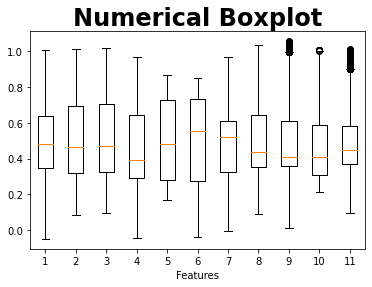

In [11]:
numerical_col = [col for col in df.columns if pd.api.types.is_float_dtype(df[col])]
plt.boxplot(df[numerical_col])
plt.title('Numerical Boxplot', fontsize=24, fontweight='bold')
plt.xlabel('Features');

In [12]:
cat_feats = [col for col in train.columns if col.startswith("cat")]
num_feats = [col for col in train.columns if col.startswith("cont")]

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["variables"] = num_feats
vif["VIF"] = [variance_inflation_factor(train[num_feats].values, i) for i in range(train[num_feats].shape[1])]

In [14]:
vif = vif.sort_values(by=["VIF"], ascending=False)
vif.style.background_gradient(cmap="magma")

,variables,VIF
2,cont2,29.744462
10,cont10,27.900019
1,cont1,27.899206
7,cont7,27.551493
0,cont0,22.105590
8,cont8,16.417928
3,cont3,11.281833
9,cont9,9.496221
6,cont6,7.750972
5,cont5,7.038932


In [15]:
target = train['target'].values

columns = test.columns[1:]
columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16',
       'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'train-test'],
      dtype='object')

In [16]:
cont_cols = [col for col in columns if 'cont' in col]
cat_cols = [col for col in columns if 'cat' in col]

def label_encode(train_df, test_df, column):
    le = LabelEncoder()
    new_feature = "{}_le".format(column)
    le.fit(train_df[column].unique().tolist() + test_df[column].unique().tolist())
    train_df[new_feature] = le.transform(train_df[column])
    test_df[new_feature] = le.transform(test_df[column])
    return new_feature

le_cols = []
for feature in cat_cols:
    le_cols.append(label_encode(train, test, feature))
    
columns = cont_cols + le_cols

In [17]:
def run_rskf(train, target, clf, params):
    train_preds = np.zeros((train.shape[0], 2))
    test_preds = 0
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=34)
    for fold, (train_index, val_index) in enumerate(rskf.split(train, target)):
        print("-> Fold {}".format(fold + 1))
       
        x_train, x_valid = train.iloc[train_index][columns], train.iloc[val_index][columns]
        y_train, y_valid = target[train_index], target[val_index]
    
        model = clf(**params)
        model.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)], 
                    verbose=0,
                    early_stopping_rounds=500)
    
        train_oof_preds = model.predict_proba(x_valid)[:,1]
        train_preds[val_index, fold//5] = train_oof_preds
        test_oof_preds = model.predict_proba(test[columns])[:,1]
        test_preds += test_oof_preds / 10
        print("ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds)))
        if fold in [4, 9]:
            print("=> Overall ROC AUC Score = {}".format(roc_auc_score(target, train_preds[:, fold//5])))
    return model, test_preds

# XGBoost

In [18]:
params_xgb = {'seed':2021,
            'n_estimators':10000,
            'verbosity':1,
            'objective': 'binary:logistic',
            'eval_metric':"auc",
            'tree_method':"gpu_hist",
            'use_label_encoder':False,
            'gpu_id':0,
            'alpha':7.105038963844129,
            'colsample_bytree':0.25505629740052566,
            'gamma':0.4999381950212869,
            'reg_lambda':1.7256912198205319,
            'learning_rate':0.011823142071967673,
            'max_bin':338,
            'max_depth':8,
            'min_child_weight':2.286836198630466,
            'subsample':0.618417952155855}

clf_xgb = XGBClassifier

In [19]:
model_xgb, test_preds_xgb = run_rskf(train, target, clf_xgb , params_xgb)

-> Fold 1
ROC AUC Score = 0.8956076176177956
-> Fold 2
ROC AUC Score = 0.8979800007970735
-> Fold 3
ROC AUC Score = 0.8939402831473013
-> Fold 4
ROC AUC Score = 0.896609562315878
-> Fold 5
ROC AUC Score = 0.8939515621186679
=> Overall ROC AUC Score = 0.8956116497204543
-> Fold 6
ROC AUC Score = 0.8963477608367225
-> Fold 7
ROC AUC Score = 0.8967637235113199
-> Fold 8
ROC AUC Score = 0.8962737535051998
-> Fold 9
ROC AUC Score = 0.894838943703407
-> Fold 10
ROC AUC Score = 0.8940650989884769
=> Overall ROC AUC Score = 0.8956557373717358


In [20]:
xgb = pd.DataFrame({'id':test['id'],'target':test_preds_xgb})
xgb.to_csv('XGB.csv',index=False)

# Parameter tuning for Lightgbm via optuna

def fun(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2)
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000,10000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6]),
        'subsample': trial.suggest_uniform('subsample', 0,1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0, 0.1 ),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'cat_l2': trial.suggest_int('cat_l2',1,20),
        'device_type': 'gpu',
        'metric': 'auc', 
        'random_state': 13,
        
    }
    model = LGBMClassifier(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=200,verbose=False)
    
    preds = model.predict_proba(test_x)[:,1]
    
    auc = roc_auc_score(test_y, preds)
    
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(fun, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.


optuna.visualization.plot_optimization_history(study)

Visualize parameter importances.


optuna.visualization.plot_param_importances(study)

best_params = study.best_params

In [21]:
params_lgb = {
            'cat_smooth':89.2699690675538,
            'colsample_bytree':0.2557260109926193,
            'learning_rate':0.00918685483594994,
            'max_bin':788,
            'max_depth':81,
            'metric':"auc",
            'min_child_samples':292,
            'min_data_per_group':177,
            'n_estimators':16000,
            'n_jobs':-1,
            'num_leaves':171,
            'reg_alpha':0.7115353581785044,
            'reg_lambda':5.658115293998945,
            'subsample':0.9262904583735796,
            'subsample_freq':1,
            'verbose':-1
            }

clf_lgb = LGBMClassifier

In [22]:
model_lgb, test_preds_lgb = run_rskf(train, target, clf_lgb , params_lgb)

-> Fold 1
ROC AUC Score = 0.8958634237848013
-> Fold 2
ROC AUC Score = 0.8982981225452817
-> Fold 3
ROC AUC Score = 0.8941791112750705
-> Fold 4
ROC AUC Score = 0.8964342160198006
-> Fold 5
ROC AUC Score = 0.8938292755125155
=> Overall ROC AUC Score = 0.8957166950750188
-> Fold 6
ROC AUC Score = 0.8965125195756036
-> Fold 7
ROC AUC Score = 0.8970609483333257
-> Fold 8
ROC AUC Score = 0.8961618112907814
-> Fold 9
ROC AUC Score = 0.8948440595128937
-> Fold 10
ROC AUC Score = 0.8937900040538377
=> Overall ROC AUC Score = 0.8956684946085159


In [23]:
lgb = pd.DataFrame({'id':test['id'],'target':test_preds_lgb})
lgb.to_csv('LGB.csv',index=False)

In [24]:
comb = pd.DataFrame({'id':test['id'],'target':(test_preds_xgb + test_preds_lgb)/2 })
comb.to_csv('comb.csv',index=False)